# PW6 – Strom- und Spannungsquellen

 Solarzellen als Gleichstromquelle
---

### Elektrische Quellen
Ein Stromkreis besteht aus Erzeugern und Verbrauchern elektrischer Energie.  
Eine **Spannungsquelle** hält ihre Spannung konstant, unabhängig von der Belastung.  
Eine **Stromquelle** hält den Strom konstant, auch wenn sich der Widerstand ändert.  
In der Praxis sind beide nicht ideal – sie besitzen einen Innenwiderstand.  
Die **Solarzelle** ist eine Gleichstromquelle.

---

### Die Solarzelle
Sie wandelt Lichtenergie in elektrische Energie um (**innerer Photoeffekt**).  
Photonen mit Energie $h \nu \le \varepsilon(G)$ regen Elektronen im Halbleiter an, wodurch frei bewegliche Elektronen und Löcher entstehen.  
Durch **Dotierung** entsteht ein **p-n-Übergang** mit einer **Sperrschicht** und einem elektrischen Feld, das die Ladungsträger trennt.  

Bei Beleuchtung wirkt die Solarzelle wie eine **Stromquelle parallel zu einer Diode** – ohne Licht nur wie eine Diode.

---

### Strom-Spannungs-Kennlinie
Die Stromquelle liefert einen lichtabhängigen Strom $I_{l}$, unabhängig vom Lastwiderstand $R_{l}$:

$$
I_{ext} = I_L - I_D
$$

Zwei wichtige Punkte:
- **Kurzschlussstrom** $I(KS):  R_L = 0, \, U_{ext} = 0$
- **Leerlaufspannung** $U(LL):  R_L = \infty, \, I_{ext} = 0$

Die elektrische Leistung lautet:

$$
P_{ext} = U_{ext} \cdot I_{ext}
$$

Das Maximum $P_{max}$ tritt bei $R_{L,max}$ auf.

---

### Kurvenfüllfaktor (CFF)
$$
CFF = \frac{P_{max}}{I_{KS} \cdot U_{LL}}
$$
Er beschreibt, wie ideal die Kennlinie ist. Gute Solarzellen: $CFF \approx 0.8–0.9$

---

### Wirkungsgrad
Der Wirkungsgrad ist das Verhältnis von abgegebener elektrischer zu eingestrahlter Energie.  
Für optimale Leistung wird der Lastwiderstand elektronisch angepasst (Impedanzwandler).


Zusammenfassung (Schwächere Beleuchtung):
I_KS  = 0.191803 A
U_LL  = 1.0582 V
P_max = 0.066 W
RL@Pmax = 5.45455 Ohm
CFF   = 0.325178

Zusammenfassung (Stärkere Beleuchtung):
I_KS  = 0.321803 A
U_LL  = 1.27778 V
P_max = 0.144 W
RL@Pmax = 4.44444 Ohm
CFF   = 0.3502



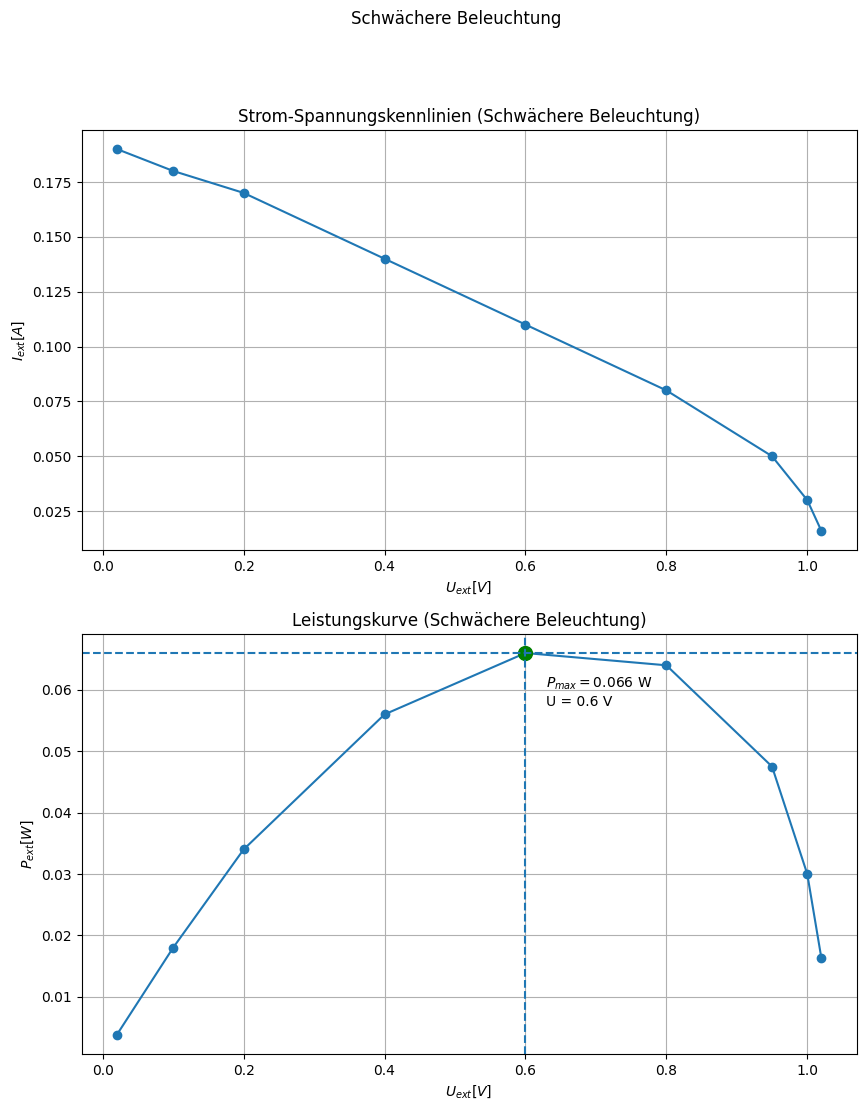

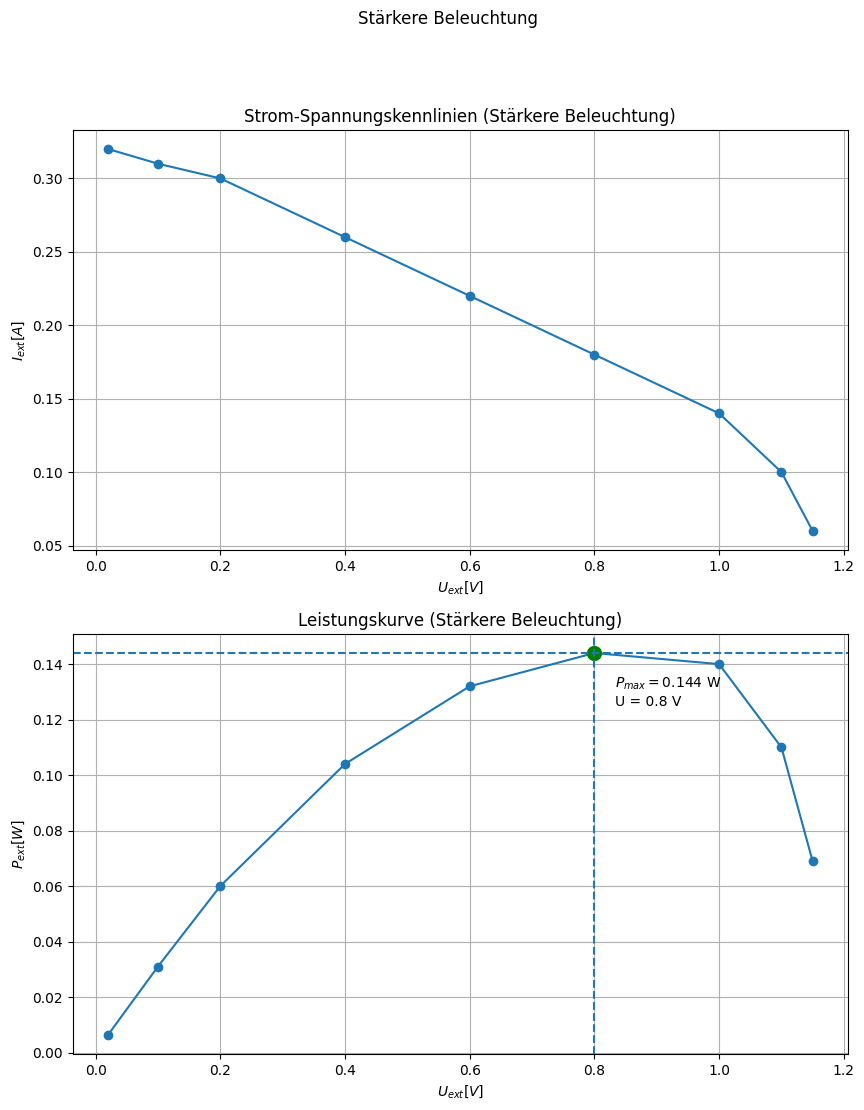

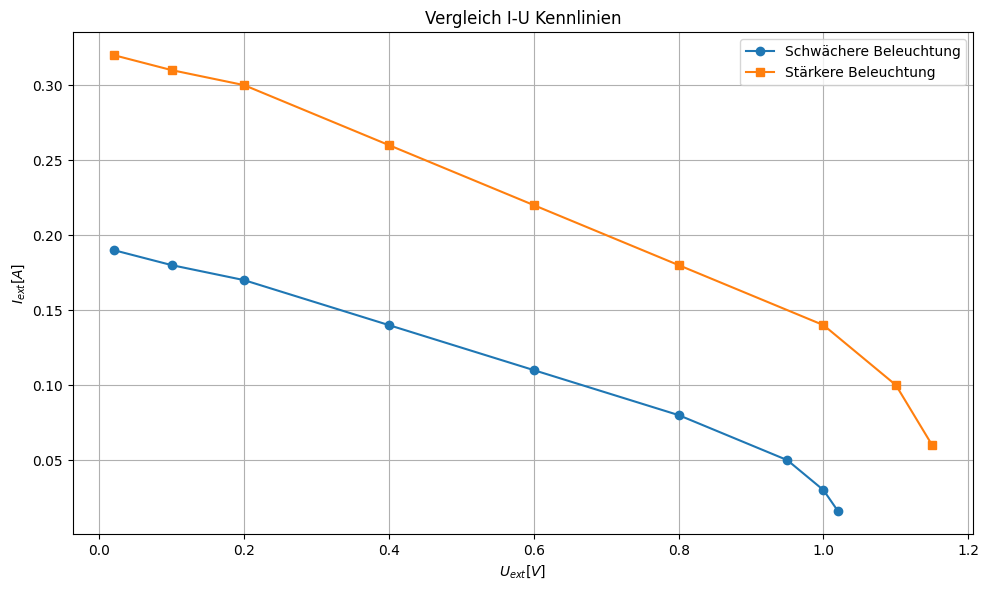

In [59]:
# -*- coding: utf-8 -*-
"""
Analyse-Toolkit fuer Experiment 1 (Solarzellen als Gleichstromquelle)
Daten werden direkt im Code eingetragen.

Hinweise:
- Kommentare sind auf Deutsch und nur ASCII-Zeichen.
- Grundlage ist PW6: I(U)-Kennlinie, Extrapolation zu I_KS und U_LL,
  Leistungskennlinie P(U), Bestimmung von P_max, R_L,max und CFF.
- Messgroessen:
  U_ext_V   = Klemmenspannung an der Solarzelle
  U_shunt_V = Spannung am Messwiderstand R_I (UI), daraus I = UI / R_I

So trage die Daten ein:
- Fuellen Sie DATA_LOW und DATA_HIGH mit Tupeln (U_ext_V, U_shunt_V)
  in aufsteigender Reihenfolge der U_ext_V (empfohlen).
- Beispiel (nur als Kommentar):
  DATA_LOW = [
      (0.02, 0.095), (0.10, 0.090), (0.20, 0.085), (0.40, 0.070),
      (0.60, 0.055), (0.80, 0.040), (0.95, 0.025), (1.00, 0.015), (1.02, 0.008)
  ]
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Dict, List

# ------------------------------
# Nutzereingaben im Code
# ------------------------------

N_FIT = 5

# Messwiderstand fuer Strommessung (R_I). Den genauen Wert vom Gehaeuse uebernehmen.
R_I_OHM = 0.5  # anpassen

# Anzahl der Randpunkte fuer lineare Extrapolation
N_FIT = 5  # anpassen je nach Punktdichte

# Rohdaten hier eintragen: Listen aus (U_ext_V, U_shunt_V)
DATA_LOW: List[Tuple[float, float]] = [ 
    # (U_ext_V, U_shunt_V)  # Beispielwerte entfernen und eigene eintragen
    (0.02, 0.095), (0.10, 0.090), (0.20, 0.085), (0.40, 0.070),
    (0.60, 0.055), (0.80, 0.040), (0.95, 0.025), (1.00, 0.015), (1.02, 0.008)
]

DATA_HIGH: List[Tuple[float, float]] = [
    (0.02, 0.160), (0.10, 0.155), (0.20, 0.150), (0.40, 0.130),
    (0.60, 0.110), (0.80, 0.090), (1.00, 0.070), (1.10, 0.050), (1.15, 0.030)
]

# Dateinamenpraefixe fuer Ausgaben
OUT_PREFIX_LOW = "Schwächere Beleuchtung"
OUT_PREFIX_HIGH = "Stärkere Beleuchtung"


@dataclass
class IVResults:
    U: np.ndarray           # Klemmenspannung
    I: np.ndarray           # Strom
    P: np.ndarray           # Leistung
    RL: np.ndarray          # Lastwiderstand
    I_KS: float             # Kurzschlussstrom (Extrapolation U->0)
    U_LL: float             # Leerlaufspannung (Extrapolation I->0)
    P_max: float            # Maximale Leistung
    RL_at_Pmax: float       # Lastwiderstand am Leistungsmaksimum
    CFF: float              # Kurvenfuellfaktor


# ------------------------------
# Hilfsfunktionen
# ------------------------------
def tuples_to_arrays(data: List[Tuple[float, float]]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Wandelt Liste von (U_ext_V, U_shunt_V) in Arrays U, UI um.
    Sortiert nach U aufsteigend, falls noetig.
    """
    if len(data) == 0:
        raise ValueError("Keine Messdaten eingetragen. Bitte DATA_LOW und DATA_HIGH befuellen.")
    arr = np.array(data, dtype=float)
    if arr.ndim != 2 or arr.shape[1] != 2:
        raise ValueError("Datenformat ungueltig. Erwartet Liste von (U_ext_V, U_shunt_V).")
    U = arr[:, 0]
    UI = arr[:, 1]
    idx = np.argsort(U)
    return U[idx], UI[idx]


def compute_current(UI: np.ndarray, R_I: float) -> np.ndarray:
    """
    I = U_shunt / R_I
    """
    return UI / R_I


def linear_extrapolation_x0(x: np.ndarray, y: np.ndarray) -> float:
    """
    Lineare Regression y = a*x + b und Rueckgabe von y(x=0) = b.
    """
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return b


def linear_extrapolation_y0(x: np.ndarray, y: np.ndarray) -> float:
    """
    Lineare Regression y = a*x + b und Rueckgabe von x bei y=0: x0 = -b/a.
    """
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    if np.isclose(a, 0.0):
        return np.nan
    return -b / a


def compute_power(U: np.ndarray, I: np.ndarray) -> np.ndarray:
    return U * I


def compute_RL(U: np.ndarray, I: np.ndarray) -> np.ndarray:
    """
    RL = U / I, mit Behandlung der Faelle nahe I=0.
    """
    RL = np.full_like(U, np.nan, dtype=float)
    nonzero = np.abs(I) > 1e-12
    RL[nonzero] = U[nonzero] / I[nonzero]
    return RL


def find_pmax(U: np.ndarray, I: np.ndarray, P: np.ndarray) -> Tuple[float, float]:
    """
    Findet P_max und den zugehoerigen RL.
    """
    idx = np.nanargmax(P)
    P_max = float(P[idx])
    RL_at = np.nan
    if np.abs(I[idx]) > 1e-12:
        RL_at = float(U[idx] / I[idx])
    return P_max, RL_at

def _auto_n_fit(n_fit_wish: int, n_points:int) -> int:
    """
    Waehlt eine sinnvolle Anzahl Randpunkte fuer lineare Extrapolation.
    Regeln:
    - mindestens 2
    - maximal n_points // 3 (damit die Randbereiche nicht zu gross sind)
    - falls sehr wenige Punkte vorhanden sind, nimmt die Funktion automatisch 2
    """
    if n_points < 4:
        # Mit <4 Punkten ist eine zuverlaessige Extrapolation nicht sinnvoll
        raise ValueError("Zu wenige Datenpunkte insgesamt. Bitte mehr Messwerte aufnehmen.")
    n = min(n_fit_wish, max(2, n_points // 3))
    n = max(2, n)  # Sicherheitsnetz
    return n

def eval_dataset(U: np.ndarray, I: np.ndarray, n_fit_wish: int) -> Dict[str, float]:
    """
    Extrapolationen:
    - I_KS: lineare Extrapolation der ersten n_fit Punkte auf U=0
    - U_LL: lineare Extrapolation der letzten  n_fit Punkte auf I=0
    """
    n_points = len(U)
    n_fit = _auto_n_fit(n_fit_wish, n_points)

    U_lo = U[:n_fit]
    I_lo = I[:n_fit]
    I_KS = float(linear_extrapolation_x0(U_lo, I_lo))
    U_hi = U[-n_fit:]
    I_hi = I[-n_fit:]
    U_LL = float(linear_extrapolation_y0(U_hi, I_hi))
    return {"I_KS": I_KS, "U_LL": U_LL}


def compute_cff(P_max: float, I_KS: float, U_LL: float) -> float:
    """
    CFF = P_max / (I_KS * U_LL)
    """
    denom = I_KS * U_LL
    if np.isclose(denom, 0.0):
        return np.nan
    return float(P_max / denom)


def analyze_from_tuples(data_tuples: List[Tuple[float, float]],
                        R_I: float,
                        n_fit: int,
                        out_prefix: str) -> IVResults:
    """
    Vollanalyse fuer einen Datensatz:
    - Umwandlung der Tupel in Arrays
    - Strom berechnen, Sortierung sicherstellen
    - Extrapolation I_KS und U_LL
    - P(U) und RL(U)
    - P_max, RL_at_Pmax, CFF
    """
    U, UI = tuples_to_arrays(data_tuples)
    I = compute_current(UI, R_I)
    P = compute_power(U, I)
    RL = compute_RL(U, I)

    ex = eval_dataset(U, I, n_fit)
    I_KS = ex["I_KS"]
    U_LL = ex["U_LL"]

    P_max, RL_at = find_pmax(U, I, P)
    idx_max = int(np.nanargmax(P))
    U_at_Pmax = float(U[idx_max])
    I_at_Pmax = float(I[idx_max])
    CFF = compute_cff(P_max, I_KS, U_LL)

    # Export Tabellen
    df_out = pd.DataFrame({
        "U_V": U,
        "U_shunt_V": UI,
        "I_A": I,
        "P_W": P,
        "RL_Ohm": RL
    })
    df_out.to_csv(f"{out_prefix}_iv_processed.csv", index=False)

    # Plots (je Plot separat, keine Farbangaben)
    fig, (ax1, ax2) = plt.subplots(2, 1,  figsize=(10, 12))
    fig.suptitle(f"{out_prefix}")
    ax1.plot(U, I, marker="o")
    ax1.set(xlabel=r"$U_{ext} [V]$", ylabel=r"$I_{ext} [A]$")
    #ax1.xlabel("U_ext (V)")
    #ax1.ylabel("I_ext (A)")
    ax1.set_title(f"Strom-Spannungskennlinien ({out_prefix})")
    ax1.grid(True)
    

    ax2.plot(U, P, marker="o")
    ax2.set(xlabel=r"$U_{ext} [V]$", ylabel=r"$P_{ext} [W]$")
    #ax2.xlabel("U_ext (V)")
    #ax2.ylabel("P_ext (W)")
    ax2.set_title(f"Leistungskurve ({out_prefix})")
    ax2.grid(True)
    ax2.plot([U_at_Pmax], [P_max], marker="o", markersize=10, color="green")
    ax2.axvline(U_at_Pmax, linestyle="--")
    ax2.axhline(P_max, linestyle="--")
    ax2.annotate(
        r"$P_{max} = $" + f"{P_max:.4g} W\nU = {U_at_Pmax:.4g} V",
        (U_at_Pmax, P_max),
        textcoords="offset points",
        xytext=(15, -40),
        ha="left",
        va="bottom"
    )
    
    # Zusammenfassung
    summary = {
        "I_KS_A": I_KS,
        "U_LL_V": U_LL,
        "P_max_W": P_max,
        "RL_at_Pmax_Ohm": RL_at,
        "CFF": CFF
    }
    pd.Series(summary).to_json(f"{out_prefix}_summary.json", indent=2)

    return IVResults(
        U=U,
        I=I, 
        P=P, 
        RL=RL,
        I_KS=I_KS, 
        U_LL=U_LL,
        P_max=P_max, 
        RL_at_Pmax=RL_at, 
        CFF=CFF
    )


# ------------------------------
# Hauptablauf
# ------------------------------
if __name__ == "__main__":
    # Pruefungen
    if len(DATA_LOW) == 0 or len(DATA_HIGH) == 0:
        raise SystemExit(
            "Bitte Messdaten in DATA_LOW und DATA_HIGH eintragen und das Skript erneut ausfuehren."
        )

    if R_I_OHM <= 0:
        raise SystemExit("R_I_OHM muss > 0 sein.")

    if N_FIT < 2:
        raise SystemExit("N_FIT sollte mindestens 2 sein.")

    # Analyse fuer beide Beleuchtungsstaerken
    res_low = analyze_from_tuples(DATA_LOW, R_I_OHM, N_FIT, OUT_PREFIX_LOW)
    res_high = analyze_from_tuples(DATA_HIGH, R_I_OHM, N_FIT, OUT_PREFIX_HIGH)

    # Vergleichsausgabe auf Konsole
    print(f"Zusammenfassung ({OUT_PREFIX_LOW}):")
    print(f"I_KS  = {res_low.I_KS:.6g} A")
    print(f"U_LL  = {res_low.U_LL:.6g} V")
    print(f"P_max = {res_low.P_max:.6g} W")
    print(f"RL@Pmax = {res_low.RL_at_Pmax:.6g} Ohm")
    print(f"CFF   = {res_low.CFF:.6g}")
    print()

    print(f"Zusammenfassung ({OUT_PREFIX_HIGH}):")
    print(f"I_KS  = {res_high.I_KS:.6g} A")
    print(f"U_LL  = {res_high.U_LL:.6g} V")
    print(f"P_max = {res_high.P_max:.6g} W")
    print(f"RL@Pmax = {res_high.RL_at_Pmax:.6g} Ohm")
    print(f"CFF   = {res_high.CFF:.6g}")
    print()

    # Optionaler Vergleichsplot
    plt.figure( figsize=(10, 6))
    plt.plot(res_low.U, res_low.I, marker="o", label=OUT_PREFIX_LOW)
    plt.plot(res_high.U, res_high.I, marker="s", label=OUT_PREFIX_HIGH)
    plt.xlabel(r"$U_{ext} [V]$")
    plt.ylabel(r"$I_{ext} [A]$")
    plt.title("Vergleich I-U Kennlinien")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Reale Spannungsquelle


### Prinzip
Eine ideale Spannungsquelle hält ihre Spannung unabhängig von der entnommenen Stromstärke konstant.  
Reale Spannungsquellen zeigen eine Abnahme der Klemmenspannung bei Belastung.  
Modell: ideale Spannungsquelle $U_0$ **in Serie** mit einem Innenwiderstand $R_i$.

---

### Zusammenhang von Spannung und Strom
Für den Stromkreis mit Lastwiderstand $R_L$:
$$
I = \frac{U_0}{R_i + R_L}
$$
Am Innenwiderstand fällt die Spannung $I\,R_i$ ab, daher:
$$
U_{\mathrm{KL}} = U_0 - I\,R_i
$$
Folgen:
- $U_{\mathrm{KL}}$ sinkt **linear** mit wachsendem $I$.  
- Nur bei $I=0$ (Leerlauf, $R_L \to \infty$) gilt $U_{\mathrm{KL}} = U_0$.

---

### Bestimmung von $R_i$ und $U_0$
Misst man die Kennlinie $U_{\mathrm{KL}}(I)$, erhält man eine fallende Gerade.  
- Steigung $-R_i$ (Betrag der Steigung entspricht $R_i$).  
- Achsenabschnitt bei $I=0$ liefert $U_0$.


=== Auswertung: Reale Spannungsquelle (PW6, Teil 2) ===
Fit-Bereich: I in [0.03, 0.07] A,  Punkte: 5
Lineares Modell: U_KL = U_0 - I * R_i  (entspricht  U = a*I + b)
Fit-Parameter:
  a = -2.75 V/A,  b = 1.6525 V,  R^2 = 0.98856

Ergebnisse:
  Innenwiderstand  R_i = 2.75 Ohm  +/- 0.17 Ohm 
  Quellenspannung  U_0 = 1.6525 V    +/- 0.0089 V

Vergleich mit Leerlaufspannung:  U_open = 1.6 V
  Abweichung U_open - U_0 = -0.0525 V


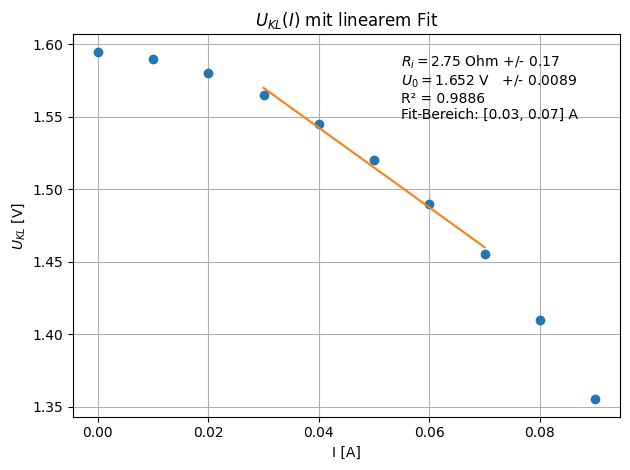

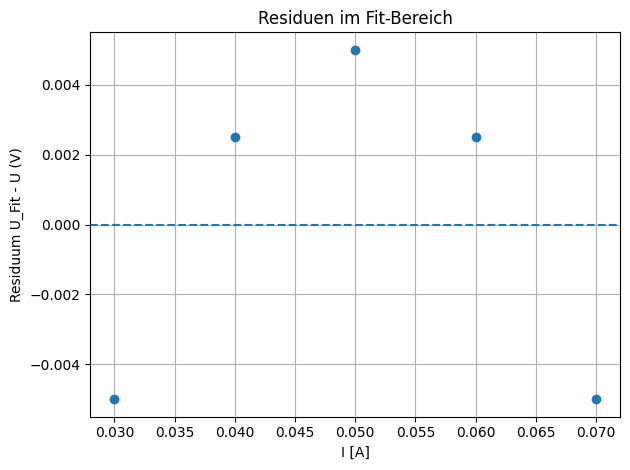

In [60]:
# -*- coding: utf-8 -*-
"""
Auswertung: Reale Spannungsquelle (Experiment 2, PW6)
- Keine Datei-Exporte: nur Konsole und angezeigte Diagramme
- Linearer Fit U_KL(I) im (auto-)gewaehlten linearen Bereich
- Bestimmung von R_i und U_0 mit Standardfehlern
- Optionaler Vergleich mit gemessener Leerlaufspannung\

Hinweis zum Modell:
U_KL = U_0 - I * R_i  -> Fit von y = a*x + b mit a ~ -R_i, b ~ U_0
"""
from typing import Optional
# ------------------------------
# Nutzereingaben
# ------------------------------

# Messdaten als Liste von Tupeln: (I_A, U_KL_V)
# Reihenfolge egal; das Skript sortiert nach I
DATA: List[Tuple[float, float]] = [
    # Beispielwerte; bitte durch eigene Messreihe ersetzen
    # (I_A, U_KL_V)
    (0.00, 1.595),
    (0.010, 1.590),
    (0.020, 1.580),
    (0.030, 1.565),
    (0.040, 1.545),
    (0.050, 1.520),
    (0.060, 1.490),
    (0.070, 1.455),
    (0.080, 1.410),
    (0.090, 1.355),
]

# Optional: gemessene Leerlaufspannung (Taster offen, I=0)
U0_OPEN_CIRCUIT_V: Optional[float] = 1.600  # oder None, wenn nicht gemessen

# Fit-Steuerung:
# Entweder expliziten Bereich in A angeben ...
FIT_I_MIN: Optional[float] = None   # z. B. 0.01
FIT_I_MAX: Optional[float] = None   # z. B. 0.07
# ... oder automatisch den "besten" linearen Abschnitt suchen
AUTO_WINDOW_MIN_POINTS = 5  # minimale Punktzahl fuer die automatische Fenstersuche


# ------------------------------
# Hilfsfunktionen
# ------------------------------
def sort_by_current(data):
    arr = np.array(data, dtype=float)
    idx = np.argsort(arr[:, 0])
    return arr[idx, 0], arr[idx, 1]  # I, U

def linear_fit_with_errors(x, y):
    """
    Linearer Fit y = a*x + b mit Standardfehlern.
    Rueckgabe: a, b, s_a, s_b, R2
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = len(x)
    if n < 2:
        raise ValueError("Zu wenige Punkte fuer linearen Fit.")
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    Sxx = np.sum((x - x_mean)**2)
    Sxy = np.sum((x - x_mean)*(y - y_mean))
    a = Sxy / Sxx
    b = y_mean - a * x_mean
    # Residuen und Varianz
    y_fit = a * x + b
    resid = y - y_fit
    RSS = np.sum(resid**2)
    s2 = RSS / (n - 2) if n > 2 else 0.0
    # Standardfehler (klassische Formeln)
    s_a = np.sqrt(s2 / Sxx) if Sxx > 0 else np.nan
    s_b = np.sqrt(s2 * (1.0/n + (x_mean**2) / Sxx)) if Sxx > 0 else np.nan
    # Bestimmtheitsmass
    TSS = np.sum((y - y_mean)**2)
    R2 = 1.0 - RSS / TSS if TSS > 0 else np.nan
    return a, b, s_a, s_b, R2, y_fit, resid

def choose_window_auto(I, U, min_points=5):
    """
    Sucht das Fenster mit maximalem R^2 fuer einen linearen Fit.
    Rueckgabe: slice(start, end_exclusive)
    """
    n = len(I)
    if n < min_points:
        raise ValueError("Zu wenige Datenpunkte fuer die automatische Fenstersuche.")
    best = (None, -np.inf, None)  # (slice, R2, (a,b,s_a,s_b))
    for start in range(0, n - min_points + 1):
        for end in range(start + min_points, n + 1):
            x = I[start:end]
            y = U[start:end]
            a, b, s_a, s_b, R2, _, _ = linear_fit_with_errors(x, y)
            if np.isfinite(R2) and R2 > best[1]:
                best = (slice(start, end), R2, (a, b, s_a, s_b))
    return best[0]  # bester Slice

def pick_fit_indices(I, fit_min, fit_max, auto_min_points):
    if fit_min is not None and fit_max is not None:
        sel = (I >= fit_min) & (I <= fit_max)
        idx = np.where(sel)[0]
        if len(idx) < 2:
            raise ValueError("Zu wenige Punkte im gewaehlten I-Bereich fuer den Fit.")
        return slice(idx[0], idx[-1] + 1), "manuell"
    # automatisch
    sl = choose_window_auto(I, U, min_points=auto_min_points)
    return sl, "auto"

# ------------------------------
# Hauptauswertung
# ------------------------------
if __name__ == "__main__":
    # Daten vorbereiten
    I, U = sort_by_current(DATA)

    # Fit-Bereich waehlen (manuell oder auto)
    fit_slice, fit_mode = pick_fit_indices(I, FIT_I_MIN, FIT_I_MAX, AUTO_WINDOW_MIN_POINTS)
    I_fit = I[fit_slice]
    U_fit = U[fit_slice]

    # Linearer Fit U = a*I + b
    a, b, s_a, s_b, R2, U_fit_vals, resid = linear_fit_with_errors(I_fit, U_fit)

    # Modellabbildung auf R_i und U_0
    # U_KL = U_0 - I * R_i -> a = dU/dI = -R_i, b = U_0
    R_i = -a
    s_Ri = s_a  # gleiche Groesse, Vorzeichenwechsel egal fuer die Unsicherheit
    U_0 = b
    s_U0 = s_b

    # Ausgabe fuer Protokoll
    print("=== Auswertung: Reale Spannungsquelle (PW6, Teil 2) ===")
    print(f"Fit-Bereich: I in [{I_fit.min():.6g}, {I_fit.max():.6g}] A,  Punkte: {len(I_fit)}")
    print(f"Lineares Modell: U_KL = U_0 - I * R_i  (entspricht  U = a*I + b)")
    print(f"Fit-Parameter:")
    print(f"  a = {a:.6g} V/A,  b = {b:.6g} V,  R^2 = {R2:.5f}")
    print("\nErgebnisse:")
    print(f"  Innenwiderstand  R_i = {R_i:.6g} Ohm  +/- {s_Ri:.2g} Ohm ")
    print(f"  Quellenspannung  U_0 = {U_0:.6g} V    +/- {s_U0:.2g} V")

    if U0_OPEN_CIRCUIT_V is not None:
        delta = U0_OPEN_CIRCUIT_V - U_0
        print(f"\nVergleich mit Leerlaufspannung:  U_open = {U0_OPEN_CIRCUIT_V:.6g} V")
        print(f"  Abweichung U_open - U_0 = {delta:.6g} V")

    # Diagramm 1: U_KL(I) mit Fit (nur ein Plot, keine Farben vorgegeben)
    plt.figure()
    plt.plot(I, U, marker="o", linestyle="")
    # Fit-Linie ueber dem Fitbereich
    I_line = np.linspace(I_fit.min(), I_fit.max(), 100)
    U_line = a * I_line + b
    plt.plot(I_line, U_line, linestyle="-")
    plt.xlabel("I [A]")
    plt.ylabel(r"$U_{KL}$ [V]")
    plt.title(r"$U_{KL}(I)$ mit linearem Fit")
    plt.grid(True)
    # Textbox mit Ergebnissen
    txt = (r"$R_i = $" + f"{R_i:.4g} Ohm +/- {s_Ri:.2g}\n"
           r"$U_0 =$"+ f"{U_0:.4g} V   +/- {s_U0:.2g}\n"
           f"R² = {R2:.4f}\n"
           f"Fit-Bereich: [{I_fit.min():.3g}, {I_fit.max():.3g}] A")
    plt.annotate(txt, xy=(0.6, 0.95), xycoords="axes fraction",
                 ha="left", va="top")

    plt.tight_layout()
    plt.show()

    # Diagramm 2: Residuenplot zur Pruefung der Linearitaet
    plt.figure()
    plt.plot(I_fit, resid, marker="o", linestyle="")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("I [A]")
    plt.ylabel("Residuum U_Fit - U (V)")
    plt.title("Residuen im Fit-Bereich")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
